# Peak Fitting in Synthetic XRD-CT Datasets

## 📝 Introduction

In this notebook, we explore **peak-based analysis** of synthetic XRD-CT datasets generated using the `nDTomo` package. Having already performed unsupervised analysis (e.g. PCA, NMF, clustering) on this dataset, we now focus on **quantitative extraction of diffraction peak parameters**, which is essential in many real-world applications of XRD-CT.

This step mimics the **final stage of XRD-CT data analysis**, where we move beyond general pattern recognition and into **parametric modelling of Bragg reflections** — enabling phase quantification, strain mapping, and microstructural analysis.

## 🎯 Objectives

By the end of this notebook, you will:
- Re-use the synthetic phantom XRD-CT dataset generated previously
- Perform background subtraction and identify key peaks
- Fit diffraction patterns using both single-peak and multi-peak models
- Generate 2D chemical maps based on extracted peak intensities, positions, or FWHM
- Evaluate the effectiveness of peak fitting on clean, controlled data

## 🧪 Why Peak Fitting?

While clustering and unmixing methods can reveal overall trends, **peak fitting allows you to extract phase-specific parameters** with physical meaning:

- **Peak position** → Lattice parameter / strain
- **Peak area** → Phase abundance
- **Peak width** → Crystallite size or microstrain (via Scherrer or Williamson-Hall)

These metrics are especially valuable in:
- Operando catalyst studies
- Battery material evolution
- Polymorphism detection
- Crystallinity and size analysis

Even in synthetic datasets, peak fitting provides a crucial benchmark to test the limits of resolution and accuracy.

## 📦 Dataset

We will re-use the same synthetic phantom XRD-CT dataset created earlier:

- 5 chemical components (Al, Cu, Fe, Pt, Zn)
- 2D spatial images for each component
- Simulated diffraction patterns for each pixel

The volume has shape:

$$
(x, y, q) = (200, 200, 250)
$$

where $q$ is the diffraction axis (e.g., $2\theta$ or $q$-space).

We now begin by importing the relevant packages and loading the synthetic volume.

## 🧪 Generate the Synthetic XRD-CT Phantom

Before we begin fitting diffraction peaks, we must first simulate a synthetic chemical tomography dataset using `nDTomo`. This dataset mimics the type of data produced in real XRD-CT experiments, where each pixel contains a full diffraction pattern (rather than a single intensity value).

We simulate 5 chemical components (Al, Cu, Fe, Pt, Zn), each defined by:
- A **reference diffraction pattern** (1D)
- A **2D spatial image** showing where the phase is located

These are linearly combined into a 3D dataset of shape $(x, y, q)$, where each spatial pixel has its own composite diffraction pattern.

### 📥 Load Spectra and Spatial Maps

We begin by importing the simulated diffraction patterns and the corresponding phantom images.

Next we generate a 3D synthetic XRD-CT volume by assigning spectra to spatial regions. Each pixel's diffraction pattern is a weighted sum of the reference patterns based on the phase distribution images.


<KeysViewHDF5 ['Al', 'Cu', 'Fe', 'Pt', 'Zn', 'q', 'tth']>


/home/antonyvam/anaconda3/envs/ndtomo/lib/python3.8/site-packages/xdesign/geometry/area.py:789: UserWarning: Didn't check that Mesh contains Circle.
  warnings.warn("Didn't check that Mesh contains Circle.")


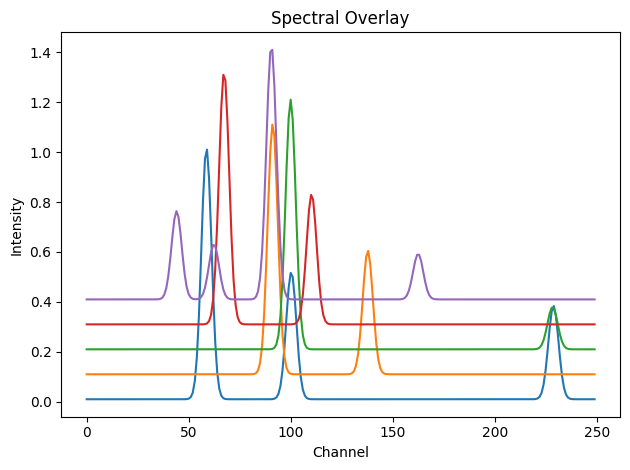

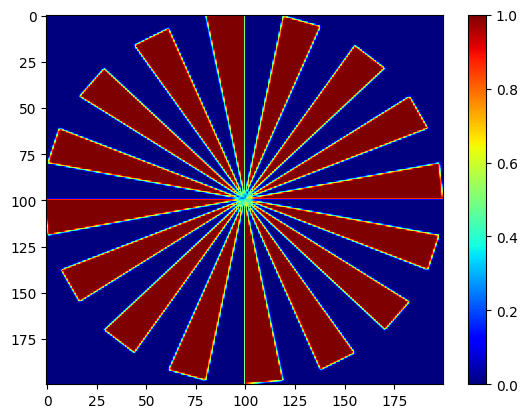

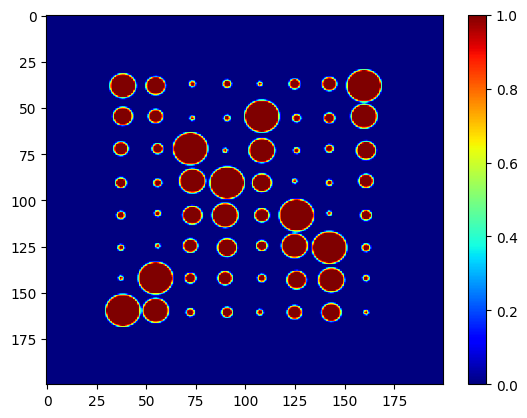

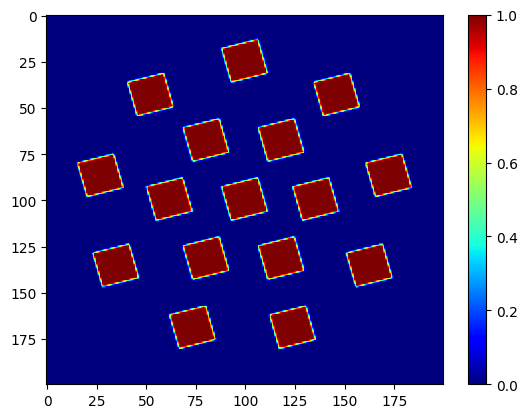

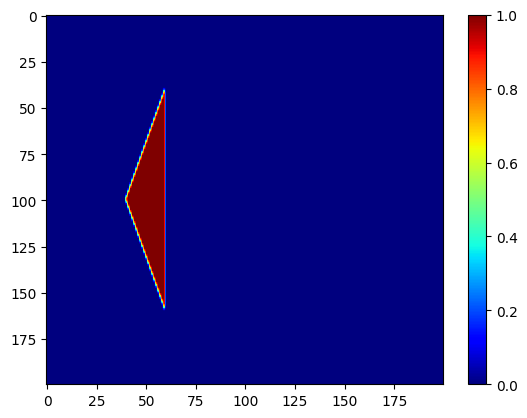

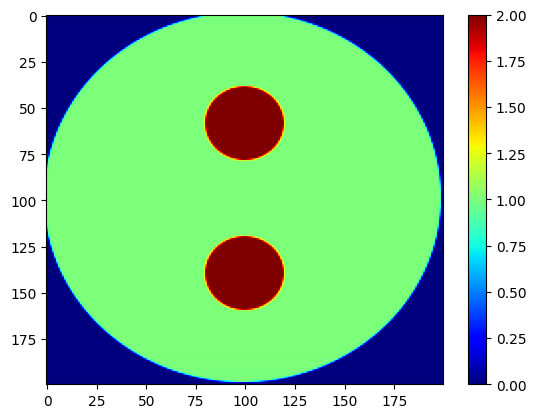

100%|██████████| 5/5 [00:03<00:00,  1.51it/s]

Phantom volume shape: (200, 200, 250)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nDTomo.sim.phantoms import load_example_patterns, nDTomophantom_2D, nDTomophantom_3D
from nDTomo.methods.plots import showspectra, showim

# Load five example diffraction patterns
dpAl, dpCu, dpFe, dpPt, dpZn, tth, q = load_example_patterns()
spectra = [dpAl, dpCu, dpFe, dpPt, dpZn]

# Create 2D spatial images for the five components
npix = 200
imAl, imCu, imFe, imPt, imZn = nDTomophantom_2D(npix, nim='Multiple')
iml = [imAl, imCu, imFe, imPt, imZn]

# Visualise spectra with vertical offsets
showspectra([dpAl, dpCu + 0.1, dpFe + 0.2, dpPt + 0.3, dpZn + 0.4], fig_num=1)

# Optionally display spatial maps
showim(imAl, 2)
showim(imCu, 3)
showim(imFe, 4)
showim(imPt, 5)
showim(imZn, 6)

chemct = nDTomophantom_3D(npix, use_spectra='Yes', spectra=spectra, imgs=iml, indices='All', norm='No')
print("Phantom volume shape:", chemct.shape)

We can now interactively explore the spectral content of this volume using the chemimexplorer

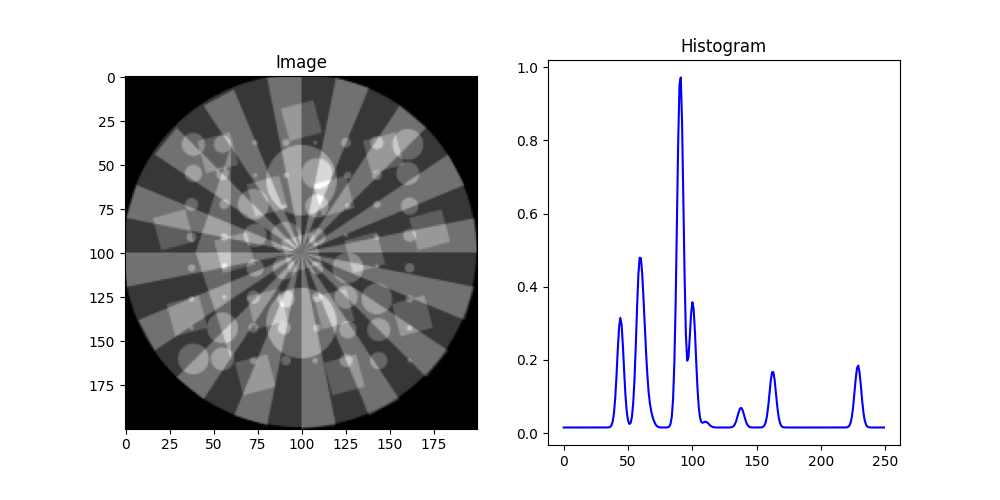

In [2]:
from nDTomo.methods.hyperexpl import chemimexplorer
                
%matplotlib widget
    
# Create an instance of the GUI
gui = chemimexplorer(chemct)

Let’s examine the mean diffraction pattern across the entire sample. This helps identify regions for peak fitting.

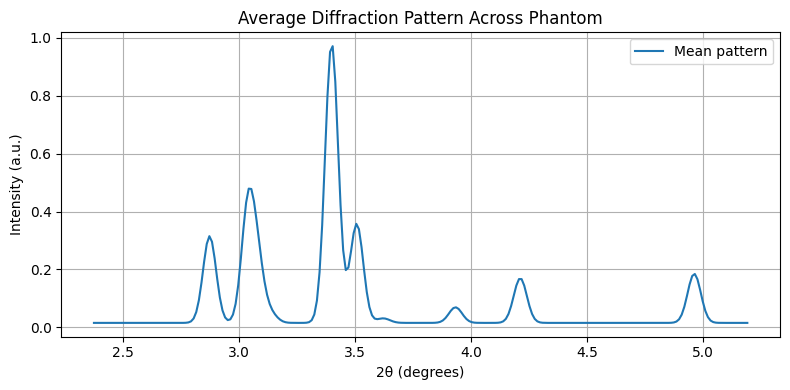

In [5]:
%matplotlib inline

mean_pattern = chemct.mean(axis=(0, 1))

plt.figure(figsize=(8,4))
plt.plot(tth, mean_pattern, label='Mean pattern')
plt.xlabel("2θ (degrees)")
plt.ylabel("Intensity (a.u.)")
plt.title("Average Diffraction Pattern Across Phantom")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()